<div style="text-align: center;">

# **Spring 2026 &mdash; CIS 3813<br>Advanced Data Science<br>(Introduction to Machine Learning)**
### Week 5: Cross-Validation & Model Selection

</div>

**Date:** 23 February 2026
**Time:** 6:00–9:00 PM  
**Instructor:** Dr. Patrick T. Marsh  
**Course Verse:** "He has shown you, O mortal, what is good. And what does the Lord require of you? To act justly and to love mercy and to walk humbly with your God."  &mdash; *Micah 6:8 (NIV)*

---

## **Week 5 Learning Objectives**

By the end of this lecture, you will be able to:
1. Explain why simple train/test splits are insufficient for robust model evaluation
2. Implement K-Fold Cross-Validation using scikit-learn
3. Use GridSearchCV for systematic hyperparameter tuning
4. Use RandomizedSearchCV for efficient hyperparameter search in large spaces
5. Build complete ML pipelines that integrate preprocessing and cross-validation

---

## **Today's Outline**
- Lecture  
    1. Review of Last Week
- Break (10-15 Minutes)
- Lab (or Homework)
- Review


---

## **Opening Reflection**

> *"Examine yourselves to see whether you are in the faith; test yourselves. Do you not realize that Christ Jesus is in you—unless, of course, you fail the test?"*  
> — **2 Corinthians 13:5 (NIV)**

Just as Paul encourages the Corinthians to examine and test their faith, we as data scientists must rigorously examine and test our models. Cross-validation is our method of "testing" whether our models truly generalize to new situations or whether they've merely memorized the training data. 

In both faith and data science, superficial success can mask deeper problems. A model that performs perfectly on training data but fails on new data is like faith that hasn't been tested—we can't know its true strength until it's challenged. Today, we'll learn systematic methods to honestly evaluate our models and select the best approaches with integrity and humility.

As we work through these techniques, consider how the principle of honest self-examination applies not just to our models, but to our work as data scientists. Are we truly understanding our data and methods, or are we just getting results that look good on the surface?

---

## **1.1 Review of Last Week:** 

---

## **1.2 The Problem with Simple Train/Test Splits**

### **1.2.1 The Standard Approach (and Its Limitations)**

So far, we've been using a simple approach to evaluate our models:

1. Split data into training set (e.g., 80%) and test set (e.g., 20%)
2. Train the model on training data
3. Evaluate on test data
4. Report the test score as our model's performance

This seems reasonable, but there's a hidden problem: **the test score depends heavily on which specific samples ended up in the test set.**

Think about it this way: if you happened to get an "easy" test set (samples that are similar to the training data), your model will look great. If you got a "hard" test set (samples that are unusual or difficult), your model will look worse—even though nothing about the model changed!

Let's see this problem in action.

### **Setting Up Our Environment**

First, let's import all the libraries we'll need for today's lecture. We're importing quite a few tools because cross-validation and hyperparameter tuning involve multiple scikit-learn modules working together.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression, fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Uncomment the following line to suppress warnings
# import warnings
# warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


### **Creating a Dataset That Shows Variability**

To demonstrate why single train/test splits can be misleading, we'll use a subset of the California Housing dataset. Using a smaller sample size makes the variability more apparent—with thousands of samples, the law of large numbers tends to smooth things out.

In the real world, you might encounter situations where:
- Your dataset is genuinely small (medical studies, rare events)
- You're working with a subset of data for initial exploration
- Your data has high variability or outliers

In all these cases, the variability problem is magnified.

In [23]:
# Load California Housing and take a subset to show more variability
california = fetch_california_housing()
X_full, y_full = california.data, california.target

# Take a random subset of 300 samples - small enough to show variability
np.random.seed(42)
subset_idx = np.random.choice(len(X_full), size=300, replace=False)
X = X_full[subset_idx]
y = y_full[subset_idx]

print(f"Working with {len(X)} samples and {X.shape[1]} features")
print(f"Features: {california.feature_names}")

Working with 300 samples and 8 features
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


### **Demonstrating the Variability Problem**

Now, let's train the exact same model (Ridge regression with alpha=1.0) multiple times, but with different random train/test splits. If our evaluation method were reliable, we'd expect to get similar scores each time.

Watch what actually happens:

In [24]:
# Demonstrate variability in test scores with different random splits
test_scores = []

# Scale features first (we'll use the same scaler approach for all splits)
scaler = StandardScaler()

print("Training Ridge(alpha=1.0) with 20 different random splits...\n")

for i in range(20):
    # Different random_state each time = different split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=i
    )

    # Scale features (fit on train, transform both)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate
    model = Ridge(alpha=1.0)
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)
    test_scores.append(score)

print(f"Test R² scores across 20 different splits:")
print(f"  Mean:  {np.mean(test_scores):.4f}")
print(f"  Std:   {np.std(test_scores):.4f}")
print(f"  Min:   {np.min(test_scores):.4f}")
print(f"  Max:   {np.max(test_scores):.4f}")
print(f"  Range: {np.max(test_scores) - np.min(test_scores):.4f}")

Training Ridge(alpha=1.0) with 20 different random splits...

Test R² scores across 20 different splits:
  Mean:  0.5900
  Std:   0.1174
  Min:   0.3242
  Max:   0.7391
  Range: 0.4149


### **Visualizing the Variability**

Let's create a bar chart to see just how much our "model performance" varies based purely on the luck of which samples ended up in the test set. Remember: this is the **exact same model** trained 20 times!

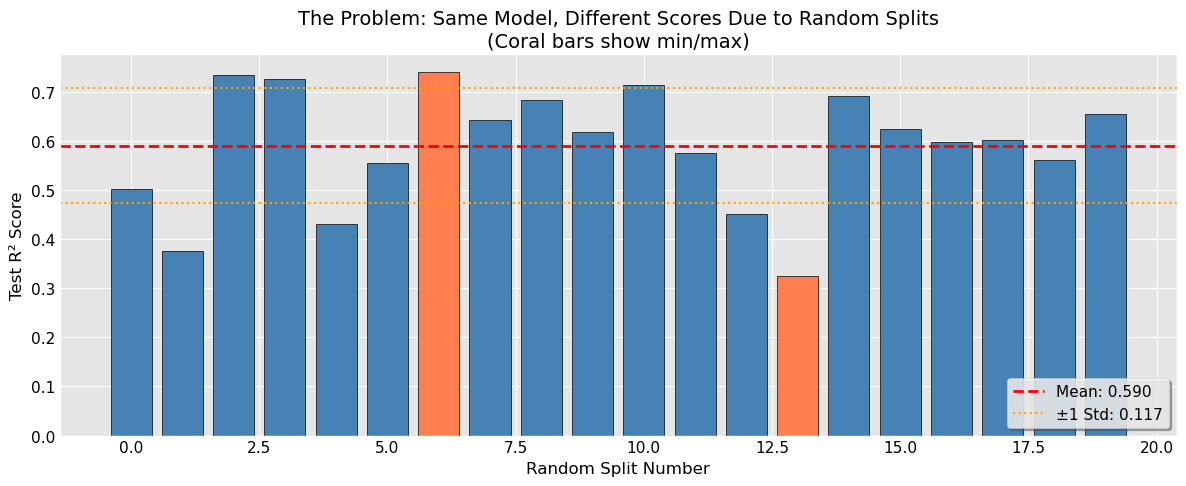


   KEY INSIGHT:
   ------------
   The same model can appear to have very different performance
   depending on which random split we happen to use!

   If you reported split #0, you'd say R² = 0.502
   If you reported split #5, you'd say R² = 0.555
   Neither is wrong, but neither tells the whole story.


In [31]:
# Visualize the variability
plt.figure(figsize=(12, 5))

colors = ['coral' if s == min(test_scores) or s == max(test_scores) else 'steelblue'
          for s in test_scores]

bars = plt.bar(range(20), test_scores, color=colors, edgecolor='black')
plt.axhline(y=np.mean(test_scores), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {np.mean(test_scores):.3f}')
plt.axhline(y=np.mean(test_scores) + np.std(test_scores), color='orange',
            linestyle=':', label=f'±1 Std: {np.std(test_scores):.3f}')
plt.axhline(y=np.mean(test_scores) - np.std(test_scores), color='orange', linestyle=':')

plt.xlabel('Random Split Number', fontsize=12)
plt.ylabel('Test R² Score', fontsize=12)
plt.title('The Problem: Same Model, Different Scores Due to Random Splits\n(Coral bars show min/max)',
          fontsize=14)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

print("\n   KEY INSIGHT:")
print("   ------------")
print("   The same model can appear to have very different performance")
print("   depending on which random split we happen to use!")
print(f"\n   If you reported split #0, you'd say R² = {test_scores[0]:.3f}")
print(f"   If you reported split #5, you'd say R² = {test_scores[5]:.3f}")
print("   Neither is wrong, but neither tells the whole story.")

### **The Implications**

This variability has serious real-world consequences:

1. **Unreliable model comparisons**: If Model A scores 0.75 and Model B scores 0.73 on a single split, can we really say A is better? The difference might just be luck.

2. **Hyperparameter selection problems**: How do we choose the best alpha for Ridge regression if the "best" alpha changes depending on the split?

3. **Overconfident deployment**: A model that happened to get a favorable test split might perform worse in production than expected.

**We need a more robust evaluation method.** Enter: Cross-Validation.

---

## 1.3 **K-Fold Cross-Validation: A More Reliable Approach**

### **The Core Idea**

**K-Fold Cross-Validation** addresses the variability problem by using ALL of your data for both training and testing—just not at the same time. Here's how it works:

1. **Divide** your data into K equal parts called "folds" (typically K=5 or K=10)
2. **Train** your model K times, each time:
   - Use K-1 folds for training
   - Use the remaining 1 fold for testing
3. **Rotate** which fold is the test fold each time
4. **Average** the K test scores to get your final performance estimate

This means:
- Every sample gets used for testing exactly once
- Every sample gets used for training K-1 times
- You get K different performance measurements to average

### **Why K=5 is Common**

With 5-fold CV:
- Each fold uses 80% of data for training (similar to a typical train/test split)
- You get 5 different estimates, which is enough to compute a meaningful average and standard deviation
- It's computationally reasonable (5x the training time of a single split)

K=10 is also popular when you have enough data and computational resources.

### **Visualizing K-Fold Splits**

Let's create a visual representation of how 5-fold cross-validation divides the data. Each row shows one "fold" of the CV process, with the test portion highlighted.

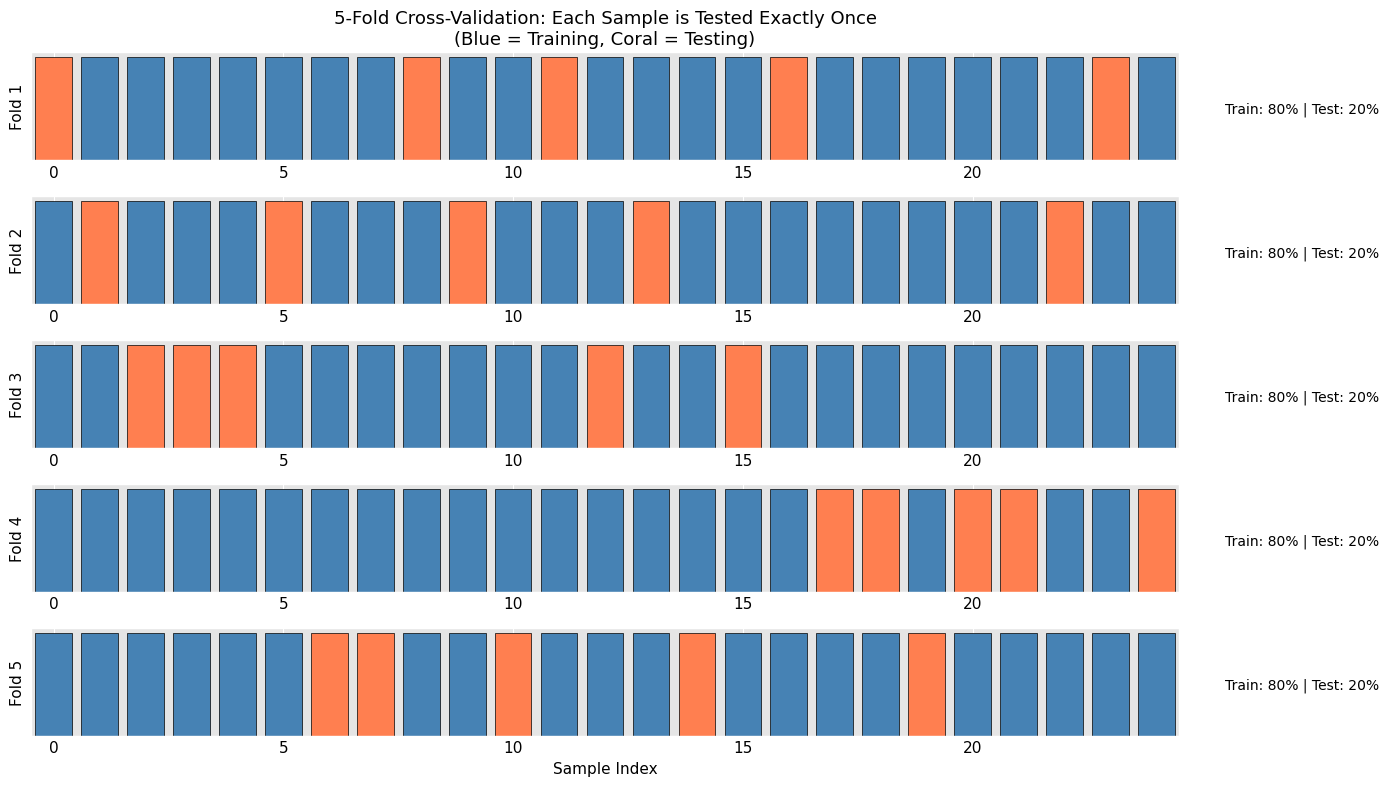

Notice how every sample (every position) is coral exactly once across all 5 folds.
This ensures every data point contributes to both training and evaluation.


In [32]:
# Visualize K-Fold splits
from sklearn.model_selection import KFold

# Create a small example dataset for visualization
n_samples = 25
X_example = np.arange(n_samples).reshape(-1, 1)

# Create 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fig, axes = plt.subplots(5, 1, figsize=(14, 8))

for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X_example)):
    ax = axes[fold_idx]

    # Create color array
    colors = ['steelblue'] * n_samples
    for idx in test_idx:
        colors[idx] = 'coral'

    ax.bar(range(n_samples), [1]*n_samples, color=colors, edgecolor='black')
    ax.set_ylabel(f'Fold {fold_idx + 1}', fontsize=11)
    ax.set_yticks([])
    ax.set_xlim(-0.5, n_samples - 0.5)

    # Add annotations
    train_pct = len(train_idx) / n_samples * 100
    test_pct = len(test_idx) / n_samples * 100
    ax.text(n_samples + 0.5, 0.5, f'Train: {train_pct:.0f}% | Test: {test_pct:.0f}%',
            va='center', fontsize=10)

    if fold_idx == 0:
        ax.set_title('5-Fold Cross-Validation: Each Sample is Tested Exactly Once\n(Blue = Training, Coral = Testing)',
                     fontsize=13)
    if fold_idx == 4:
        ax.set_xlabel('Sample Index', fontsize=11)

plt.tight_layout()
plt.show()

print("Notice how every sample (every position) is coral exactly once across all 5 folds.")
print("This ensures every data point contributes to both training and evaluation.")

### **Implementing K-Fold Cross-Validation Manually**

To truly understand how cross-validation works, let's implement it step-by-step before using scikit-learn's convenience functions. This will help you debug issues and understand what's happening "under the hood."

In [33]:
# Manual K-Fold Cross-Validation implementation
from sklearn.model_selection import KFold

# Create the KFold splitter
# shuffle=True randomizes before splitting (important if data is ordered!)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_scores = []
fold_details = []

print("Manual 5-Fold Cross-Validation Process:")
print("=" * 70)

for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    # Step 1: Split data according to this fold's indices
    X_train_fold = X[train_idx]
    X_test_fold = X[test_idx]
    y_train_fold = y[train_idx]
    y_test_fold = y[test_idx]

    # Step 2: Scale features (fit on training fold only!)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_test_scaled = scaler.transform(X_test_fold)  # Use same scaling params

    # Step 3: Train the model
    model = Ridge(alpha=1.0)
    model.fit(X_train_scaled, y_train_fold)

    # Step 4: Evaluate on the test fold
    score = model.score(X_test_scaled, y_test_fold)
    fold_scores.append(score)

    print(f"Fold {fold}:")
    print(f"  Training samples: {len(train_idx)} | Test samples: {len(test_idx)}")
    print(f"  R² Score: {score:.4f}")
    print()

print("=" * 70)
print(f"FINAL CROSS-VALIDATION RESULT:")
print(f"  Mean R²: {np.mean(fold_scores):.4f}")
print(f"  Std R²:  {np.std(fold_scores):.4f}")
print(f"\n  Interpretation: Our model achieves R² = {np.mean(fold_scores):.3f} ± {np.std(fold_scores):.3f}")

Manual 5-Fold Cross-Validation Process:
Fold 1:
  Training samples: 240 | Test samples: 60
  R² Score: 0.7027

Fold 2:
  Training samples: 240 | Test samples: 60
  R² Score: 0.5666

Fold 3:
  Training samples: 240 | Test samples: 60
  R² Score: 0.4996

Fold 4:
  Training samples: 240 | Test samples: 60
  R² Score: 0.5802

Fold 5:
  Training samples: 240 | Test samples: 60
  R² Score: 0.6742

FINAL CROSS-VALIDATION RESULT:
  Mean R²: 0.6047
  Std R²:  0.0742

  Interpretation: Our model achieves R² = 0.605 ± 0.074


### **The Easy Way: `cross_val_score`**

Now that we understand what's happening, let's use scikit-learn's `cross_val_score` function, which does all of this in one line. This is what you'll typically use in practice.

**Important caveat:** `cross_val_score` doesn't automatically scale your data! If you need scaling (and you usually do for regularized models), you'll need to use a Pipeline (which we'll cover later) or scale beforehand.

In [34]:
# The easy way: cross_val_score
from sklearn.model_selection import cross_val_score

# First, scale all features (note: this is slightly incorrect - more on this later!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create model
model = Ridge(alpha=1.0)

# Perform 5-fold CV in one line!
cv_scores = cross_val_score(
    model,          # The model to evaluate
    X_scaled,       # Features
    y,              # Target
    cv=5,           # Number of folds
    scoring='r2'    # Metric to use
)

print("Using cross_val_score (one line!):")
print(f"  Individual fold scores: {cv_scores.round(4)}")
print(f"  Mean R²: {cv_scores.mean():.4f} (± {cv_scores.std():.4f})")

Using cross_val_score (one line!):
  Individual fold scores: [0.641  0.4498 0.7153 0.7015 0.4716]
  Mean R²: 0.5958 (± 0.1133)


### **Understanding Scoring Metrics**

The `scoring` parameter in `cross_val_score` determines how we measure model performance. Different metrics are appropriate for different situations. Here's a comprehensive guide:

#### **Regression Metrics**

| Scoring Parameter | Description | Interpretation |
|-------------------|-------------|----------------|
| `'r2'` | R² (coefficient of determination) | Proportion of variance explained. Range: -∞ to 1.0. Higher is better. |
| `'neg_mean_squared_error'` | Negative MSE | Average squared error. Penalizes large errors heavily. |
| `'neg_root_mean_squared_error'` | Negative RMSE | Square root of MSE. Same units as target variable. |
| `'neg_mean_absolute_error'` | Negative MAE | Average absolute error. More robust to outliers than MSE. |

#### **Classification Metrics (Preview for Week 6+)**

| Scoring Parameter | Description | Best For |
|-------------------|-------------|----------|
| `'accuracy'` | Proportion correct | Balanced datasets |
| `'f1'` | Harmonic mean of precision & recall | Imbalanced datasets |

#### **Why Negative Values?**

Scikit-learn's convention is that **higher scores = better performance** for all metrics. Since MSE, RMSE, and MAE are error metrics (lower = better), scikit-learn negates them so that maximizing the negative error is equivalent to minimizing the actual error. This allows `GridSearchCV` to always search for the maximum value regardless of which metric you choose.

#### **Regression Metrics Explained**

**R² (Coefficient of Determination)**
- Measures the proportion of variance in the target variable explained by the model
- Ranges from -∞ to 1.0 (1.0 = perfect, 0 = no better than predicting the mean)
- Interpretation: "My model explains 85% of the variance in house prices"
- Best for: Comparing models on the same dataset, communicating to non-technical audiences

**MSE (Mean Squared Error)**
- Average of squared differences between predicted and actual values
- Penalizes large errors heavily (squaring amplifies big mistakes)
- Units are squared (e.g., dollars²), making interpretation less intuitive
- Best for: When large errors are particularly costly and should be avoided

**RMSE (Root Mean Squared Error)**
- Square root of MSE, bringing units back to original scale
- Interpretation: "On average, my predictions are off by about $25,000"
- Same error-weighting as MSE but more interpretable
- Best for: When you want an intuitive "average error" in original units

**MAE (Mean Absolute Error)**
- Average of absolute differences between predicted and actual values
- Treats all errors equally; more robust to outliers than MSE/RMSE
- Best for: When outliers exist and you don't want them dominating the metric

#### **Classification Metrics Explained**

**Accuracy**
- Proportion of correct predictions
- Simple but misleading with imbalanced classes (e.g., 95% "not spam" data → predicting "not spam" always yields 95% accuracy but is useless)
- Best for: Balanced datasets where all classes matter equally

**F1 Score**
- Harmonic mean of precision and recall; balances false positives and false negatives
- Ranges from 0 to 1 (higher is better)
- Best for: Imbalanced datasets, when both types of errors matter

#### **When to use which metric:**
- **R²**: Great for comparing models, easy to explain ("explains 85% of variance")
- **RMSE**: When you want error in original units ("predictions off by ~$25,000 on average")
- **MAE**: When outliers exist and shouldn't dominate evaluation
- **MSE**: When large errors are especially costly (squaring amplifies big mistakes)

In [40]:
# Demonstrating different scoring metrics
model = Ridge(alpha=1.0)

print("Same model, different evaluation metrics:")
print("=" * 60)

# R² score
r2_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')
print(f"\nR² Score:")
print(f"  Scores: {r2_scores.round(4)}")
print(f"  Mean: {r2_scores.mean():.4f} (± {r2_scores.std():.4f})")
print(f"  Interpretation: Model explains {r2_scores.mean()*100:.1f}% of variance")

# Negative RMSE (most interpretable error metric)
rmse_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"\nRMSE (Root Mean Squared Error):")
print(f"  Raw scores: {rmse_scores.round(4)}")
print(f"  Actual RMSE: {-rmse_scores.mean():.4f} (± {rmse_scores.std():.4f})")
print(f"  Interpretation: Predictions off by ~${-rmse_scores.mean()*100000:,.0f} on average")
print(f"  (Note: California housing target is in $100,000s)")

# Negative MAE
mae_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_absolute_error')
print(f"\nMAE (Mean Absolute Error):")
print(f"  Raw scores: {mae_scores.round(4)}")
print(f"  Actual MAE: {-mae_scores.mean():.4f}")
print(f"  Interpretation: Typical prediction error is ${-mae_scores.mean()*100000:,.0f}")

Same model, different evaluation metrics:

R² Score:
  Scores: [0.641  0.4498 0.7153 0.7015 0.4716]
  Mean: 0.5958 (± 0.1133)
  Interpretation: Model explains 59.6% of variance

RMSE (Root Mean Squared Error):
  Raw scores: [-0.6646 -0.7751 -0.568  -0.7021 -0.8031]
  Actual RMSE: 0.7026 (± 0.0836)
  Interpretation: Predictions off by ~$70,258 on average
  (Note: California housing target is in $100,000s)

MAE (Mean Absolute Error):
  Raw scores: [-0.5053 -0.5051 -0.4271 -0.5265 -0.5737]
  Actual MAE: 0.5075
  Interpretation: Typical prediction error is $50,753


---

## **1.4 Hyperparameter Tuning with GridSearchCV**

### **The Hyperparameter Problem**

Now that we have a reliable way to evaluate models, we can tackle a crucial question: **how do we choose the best hyperparameters?**

Recall from last week that Ridge regression has an `alpha` hyperparameter that controls regularization strength:
- Too low → Model may overfit (not enough regularization)
- Too high → Model may underfit (too much regularization)
- Just right → Model generalizes well

We could manually try different alpha values and compare their cross-validation scores, but this is tedious and error-prone. **GridSearchCV automates this process.**

### **How GridSearchCV Works**

1. You define a "grid" of hyperparameter values to try (e.g., alpha = [0.01, 0.1, 1.0, 10.0])
2. GridSearchCV trains and evaluates a model for EVERY combination in the grid
3. Each evaluation uses K-fold cross-validation (so it's reliable!)
4. GridSearchCV returns the best hyperparameters and a model trained with those parameters

### **Computational Cost**

Be aware that GridSearchCV can be computationally expensive:
- 6 alpha values × 5 folds = 30 model fits
- If you have 2 hyperparameters with 6 values each: 6 × 6 × 5 = 180 model fits!

This "curse of dimensionality" in hyperparameter space is why RandomizedSearchCV exists (covered later).

### **Setting Up GridSearchCV for Ridge Regression**

Let's use the full California Housing dataset now for more realistic results, and find the optimal alpha for Ridge regression.

In [41]:
# Load full California Housing dataset
california = fetch_california_housing()
X_cal, y_cal = california.data, california.target

print(f"California Housing Dataset:")
print(f"  Samples: {X_cal.shape[0]:,}")
print(f"  Features: {X_cal.shape[1]}")
print(f"  Feature names: {california.feature_names}")
print(f"  Target: Median house value (in $100,000s)")
print(f"  Target range: ${y_cal.min()*100000:,.0f} - ${y_cal.max()*100000:,.0f}")

California Housing Dataset:
  Samples: 20,640
  Features: 8
  Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
  Target: Median house value (in $100,000s)
  Target range: $14,999 - $500,001


In [45]:
# Split into train and test sets
# IMPORTANT: We hold out a test set that we WON'T touch until final evaluation
X_train_cal, X_test_cal, y_train_cal, y_test_cal = train_test_split(
    X_cal, y_cal, test_size=0.2, random_state=42
)

print(f"Training set: {X_train_cal.shape[0]:,} samples (for CV and tuning)")
print(f"Test set: {X_test_cal.shape[0]:,} samples (held out for final evaluation)")
print("\nThe test set stays untouched until we've selected our final model!")

Training set: 16,512 samples (for CV and tuning)
Test set: 4,128 samples (held out for final evaluation)

The test set stays untouched until we've selected our final model!


In [43]:
# Scale features for regularized regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_cal)
# Note: We'll transform the test set later using the SAME scaler

### **Running GridSearchCV**

Now let's set up and run GridSearchCV. We'll search over a range of alpha values spanning several orders of magnitude (this is common for regularization parameters).

In [46]:
from sklearn.model_selection import GridSearchCV

# Step 1: Define the parameter grid
# We search over several orders of magnitude for alpha
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

print("Parameter grid to search:")
print(f"  alpha values: {param_grid['alpha']}")
print(f"  Total combinations: {len(param_grid['alpha'])}")
print(f"  With 5-fold CV: {len(param_grid['alpha']) * 5} model fits")

Parameter grid to search:
  alpha values: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
  Total combinations: 6
  With 5-fold CV: 30 model fits


In [47]:
# Step 2: Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=Ridge(),           # The model to tune
    param_grid=param_grid,       # Parameters to search
    cv=5,                        # 5-fold cross-validation
    scoring='r2',                # Metric to optimize
    return_train_score=True,     # Also record training scores (useful for diagnosis)
    verbose=1                    # Print progress
)

# Step 3: Fit GridSearchCV (this does all the work!)
print("\nRunning GridSearchCV...")
grid_search.fit(X_train_scaled, y_train_cal)
print("Done!")


Running GridSearchCV...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Done!


### **Examining GridSearchCV Results**

GridSearchCV stores detailed results about every parameter combination it tried. Let's explore these results to understand what happened during the search.

In [49]:
# View the key results
print("GridSearchCV Results Summary:")
print("=" * 60)
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")
print(f"\nThe best model is automatically stored in: grid_search.best_estimator_")

GridSearchCV Results Summary:

Best parameters found: {'alpha': 0.001}
Best CV score: 0.6115

The best model is automatically stored in: grid_search.best_estimator_


In [50]:
# Detailed results for EVERY parameter combination
results_df = pd.DataFrame(grid_search.cv_results_)

# Select the most useful columns
results_summary = results_df[[
    'param_alpha',        # The alpha value tested
    'mean_train_score',   # Average training score across folds
    'mean_test_score',    # Average validation score across folds (this is the CV score)
    'std_test_score',     # Standard deviation of validation scores
    'rank_test_score'     # Rank (1 = best)
]].copy()

results_summary.columns = ['Alpha', 'Mean Train R²', 'Mean CV R²', 'Std CV R²', 'Rank']

print("\nDetailed Results for Each Alpha Value:")
print(results_summary.to_string(index=False))

print("\n💡 Interpretation:")
print("   - 'Mean Train R²' shows how well the model fits the training data")
print("   - 'Mean CV R²' shows how well the model generalizes (this is what we optimize!)")
print("   - If Train >> CV, the model is overfitting")
print("   - If both are low, the model is underfitting")


Detailed Results for Each Alpha Value:
  Alpha  Mean Train R²  Mean CV R²  Std CV R²  Rank
  0.001       0.612650    0.611484   0.006467     1
  0.010       0.612650    0.611484   0.006467     2
  0.100       0.612650    0.611484   0.006466     3
  1.000       0.612649    0.611484   0.006460     4
 10.000       0.612639    0.611473   0.006398     5
100.000       0.611756    0.610597   0.005847     6

💡 Interpretation:
   - 'Mean Train R²' shows how well the model fits the training data
   - 'Mean CV R²' shows how well the model generalizes (this is what we optimize!)
   - If Train >> CV, the model is overfitting
   - If both are low, the model is underfitting


### **Visualizing the Validation Curve**

A **validation curve** shows how model performance changes as we vary a hyperparameter. This is one of the most important diagnostic plots in machine learning because it helps us understand the bias-variance tradeoff.

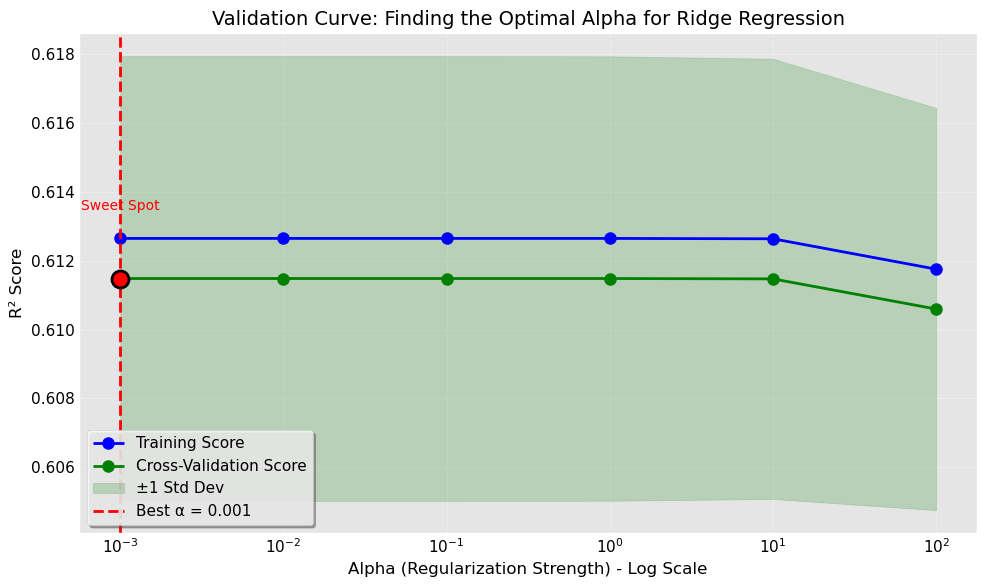


 Reading the Validation Curve:
  • Left side (low alpha): Less regularization, potential overfitting
  • Right side (high alpha): More regularization, potential underfitting
  • Gap between curves: Larger gap = more overfitting
  • Best alpha (0.001): Balances bias and variance


In [52]:
# Extract data for plotting
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores = results_df['mean_train_score']
cv_scores = results_df['mean_test_score']
cv_std = results_df['std_test_score']

# Create the validation curve plot
plt.figure(figsize=(10, 6))

# Plot training and CV scores
plt.semilogx(alphas, train_scores, 'o-', color='blue', linewidth=2,
             markersize=8, label='Training Score')
plt.semilogx(alphas, cv_scores, 'o-', color='green', linewidth=2,
             markersize=8, label='Cross-Validation Score')

# Add confidence band around CV scores
plt.fill_between(alphas, cv_scores - cv_std, cv_scores + cv_std,
                 alpha=0.2, color='green', label='±1 Std Dev')

# Mark the best alpha
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_
plt.axvline(x=best_alpha, color='red', linestyle='--', linewidth=2,
            label=f'Best α = {best_alpha}')
plt.scatter([best_alpha], [best_score], color='red', s=150, zorder=5,
            edgecolors='black', linewidth=2)

# Labels and formatting
plt.xlabel('Alpha (Regularization Strength) - Log Scale', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('Validation Curve: Finding the Optimal Alpha for Ridge Regression', fontsize=14)
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)

# Add annotations
plt.annotate('Underfitting Zone\n(too much regularization)',
             xy=(50, 0.595), fontsize=10, ha='center', color='gray')
plt.annotate('Sweet Spot', xy=(best_alpha, best_score + 0.002),
             fontsize=10, ha='center', color='red')

plt.tight_layout()
plt.show()

print("\n Reading the Validation Curve:")
print("  • Left side (low alpha): Less regularization, potential overfitting")
print("  • Right side (high alpha): More regularization, potential underfitting")
print("  • Gap between curves: Larger gap = more overfitting")
print(f"  • Best alpha ({best_alpha}): Balances bias and variance")

### **Final Evaluation on the Held-Out Test Set**

Now that we've selected our best hyperparameters using cross-validation on the training set, we can finally evaluate on our held-out test set. This gives us an unbiased estimate of how our model will perform on truly unseen data.

**Important:** We only do this ONCE, after all model selection is complete. If we kept testing and tweaking, the test set would no longer be "unseen."

In [55]:
# Get the best model (already trained on full training set by GridSearchCV)
best_model = grid_search.best_estimator_

# Transform test features using the SAME scaler we fit on training data
X_test_scaled = scaler.transform(X_test_cal)

# Evaluate on held-out test set
test_score = best_model.score(X_test_scaled, y_test_cal)

print("Final Model Evaluation:")
print("=" * 50)
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Cross-validation score: {grid_search.best_score_:.4f}")
print(f"Test set score: {test_score:.4f}")
print()
print(f"Difference (CV - Test): {grid_search.best_score_ - test_score:.4f}")

if abs(grid_search.best_score_ - test_score) < 0.02:
    print("\n Great! CV score closely matches test score.")
    print("  This suggests our cross-validation procedure was reliable.")
else:
    print("\n  There's some difference between CV and test scores.")
    print("  This can happen due to random variation or dataset shift.")

Final Model Evaluation:
Best hyperparameters: {'alpha': 0.001}
Cross-validation score: 0.6115
Test set score: 0.5758

Difference (CV - Test): 0.0357

  There's some difference between CV and test scores.
  This can happen due to random variation or dataset shift.


---

---

## **BREAK (10-15 minutes)**

---

## **2.1 Lab Exercises** (new notebook)

---

## **3.1: Review & Wrap-Up**

### **3.1.1 What We Learned Today**
| Concept | Key Idea |
|---------|----------|
| Multiple Linear Regression | $\hat{y} = w_0 + w_1 x_1 + \cdots + w_p x_p$ — uses all features |
| Regularization | Add a penalty to prevent overfitting: $\text{MSE} + \alpha \cdot \text{Penalty}$ |
| Ridge (L2) | Penalty = $\alpha \sum w_j^2$ — shrinks, never zeros |
| Lasso (L1) | Penalty = $\alpha \sum |w_j|$ — shrinks AND can zero out |
| Feature Scaling | **Required** before regularization — `StandardScaler` |
| Alpha (α) | Controls regularization strength — higher = more penalty |


### **3.1.2 Discussion Questions**

1. **The Cost of Complexity:** In our traveler analogy, how does the "baggage fee" ($\alpha$) act as a proxy for model complexity? What happens to the model when $\alpha = 0$ versus when $\alpha$ is extremely large?
2. **The Scaling Problem:** Why is it misleading to compare the "importance" of features based solely on their coefficient magnitudes if the features haven't been scaled?
3. **Geometry of Sparsity:** Based on the visualization of the L1 diamond and the L2 circle, why is the RSS "error ellipse" more likely to hit a corner in Lasso than in Ridge? What does "hitting a corner" mean for your final model?
4. **Model Selection:** If you are working with a dataset where you expect many features to be irrelevant noise, which regularization method would you choose to perform automatic feature selection?
5. **The Trade-off:** Regularization intentionally introduces a small amount of **bias** into the model. What is the benefit we receive in exchange for this added bias?

---

## **3.2 Coming Up**

### **3.2.1 Next Week Preview: Cross-Validation & Model Selection**
- Choose the best alpha without using the test set
- Compare models fairly
- Use `GridSearchCV` and `RandomizedSearchCV`
- Build complete `Pipeline` objects

### **3.2.2 Homework Reminder**
- **Lab due:** Monday, 23 February @ 6:00 PM (grace period: Wednesda, 25 February @ 11:59 PM)
- **Next week's mastery assessment** will cover tonight's material (Regularization, Ridge, Lasso)